In [2]:
import pandas as pd
import numpy as np
import stan
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [3]:
import os
os.environ['CMDSTAN'] = '/Users/indiaermacora/.cmdstan/cmdstan-2.31.0'

In [4]:
from cmdstanpy import CmdStanModel, set_cmdstan_path, cmdstan_path
import arviz as az
import os

/Users/indiaermacora/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
cmdstan_path()

'/Users/indiaermacora/.cmdstan/cmdstan-2.31.0'

In [42]:
nugget = pd.read_csv('stan/nugget_to_python.csv', sep = ";")
dati_covariates = pd.read_csv('stan/covariates.csv', sep = ";")
dat_complete_log = pd.read_csv('stan/dat_complete_log_to_python.csv', sep = ";")
ind_pres=pd.read_csv('stan/ind_pres_to_python.csv', sep = ";")
ind_miss=pd.read_csv('stan/ind_miss_to_python.csv', sep = ";")
lat_long=pd.read_csv('stan/lat_long_2_to_python.csv', sep = ";")
dat_2017_log=pd.read_csv('stan/log_dati_2017.csv', sep = ";")

In [43]:
dat_complete_log.mean()[0]

2.7607208499144247

In [44]:
matrix_dati_covariates=np.matrix(dati_covariates)
dat_2017_log_matrix= np.matrix(dat_2017_log, dtype=float)
dat_2017_log_matrix_centered= dat_2017_log_matrix-dat_complete_log.mean()[0]

quota= np.array (matrix_dati_covariates[0,:], dtype=int)
quota_norm = ((quota-quota.mean())/quota.std())

area_dummies = pd.get_dummies(dati_covariates.iloc[1, :])
zona_dummies = pd.get_dummies(dati_covariates.iloc[2, :])

all_cov = np.matrix(pd.concat([area_dummies.Urbano],axis=1),dtype=int)
all_cov = np.concatenate((np.transpose(quota_norm),all_cov),axis=1)

ind_miss = np.array(ind_miss)
ind_pres = np.array(ind_pres)
dat_complete_log= np.array(dat_complete_log, dtype=float)
dat_complete_log_centered= dat_complete_log- dat_complete_log.mean() 

nugget_mat = np.matrix(nugget, dtype=float)
coord = np.matrix( pd.concat([lat_long.Lat, lat_long.Long], axis=1) )

month=np.repeat(np.array([1,2,3,4,5,6,7,8,9,10,11,12]), [31,28,31,30,31,30,31,31,30,31,30,31])


In [45]:
#all stations

arima_model = """

data {
  int<lower=0> num_giorni;
  int<lower=0> num_stazioni;
  
  matrix[num_stazioni, 2] covariates;
  
  int Ncomp; // Number of non-missing values
  int  Nmiss; // Number of missing values
  vector [Ncomp] dat_complete;
  int ind_pres[Ncomp, 2];
  int ind_miss[Nmiss, 2];

  matrix[num_stazioni,num_stazioni] dist_w;  //distance matrix
  real phi;
  matrix[6,num_stazioni] y_2017; 
  vector[num_giorni] days;
  int mese[num_giorni];
}


parameters {
  real phi1;
  real phi2;
  real phi3;
  real theta1;
  real theta2;
  vector<lower=0>[12] sigma;
  
  real beta_0;
  vector[2] beta_cov;
  
  vector [Nmiss] dat_miss;

  real<lower=0> a;
  vector[num_stazioni] w;
  real alpha;
} 

transformed parameters{

  matrix[num_giorni, num_stazioni] y;
  matrix[num_stazioni, num_stazioni] cov_w;
  
  vector[num_giorni] epsilon[num_stazioni]; // forecast errors
  vector[num_giorni] y_hat[num_stazioni]; // predicted values
  vector[num_giorni] output[num_stazioni]; // predicted values
  
  vector[2] epsilon_2017[num_stazioni]; // forecast errors
  vector[2] y_hat_2017[num_stazioni]; // predicted values
  vector[num_giorni] fourier;
  
  
  //NA
  for (i in 1:Ncomp) {
    y[ind_pres[i,1], ind_pres[i,2]] =  dat_complete[i];
  }
  for(i in 1:Nmiss) {
    y[ind_miss[i,1], ind_miss[i,2]] = dat_miss[i];
    }
    
  //fourier
  fourier = alpha * cos(2 * pi() / 365 * days);
  
  //spatial residual
  cov_w = a*exp(-phi*dist_w);



  // Loop over the time series
  for (n in 1:num_stazioni) {
    
    //y_2017 [26, 27, 28, 29, 30, 31]
    
    //30 dicembre 2017
    y_hat_2017[n][1] = (1+phi1) * y_2017[4,n] + (phi2-phi1) * y_2017[3,n] + (phi3-phi2) * y_2017[2,n] -phi3*y_2017[1,n] + beta_0 + covariates[n,:] * beta_cov;
    epsilon_2017[n][1] = y_2017[5,n] - y_hat_2017[n][1];
    
    //31 dicembre 2017
    y_hat_2017[n][2] = (1+phi1) * y_2017[5,n] + (phi2-phi1) * y_2017[4,n] + (phi3-phi2) * y_2017[3,n] -phi3*y_2017[2,n] + theta1 * epsilon_2017[n][1] + beta_0 + covariates[n,:] * beta_cov;
    epsilon_2017[n][2] = y_2017[6,n] - y_hat_2017[n][2];
    
    //1 gennaio 2018
    y_hat[n][1] = (1+phi1) * y_2017[6,n] + (phi2-phi1) * y_2017[5,n] + (phi3-phi2) * y_2017[4,n] -phi3*y_2017[3,n] + theta1 * epsilon_2017[n][2] + theta2 * epsilon_2017[n][1] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][1] = y[1,n] - y_hat[n][1];
    
    y_hat[n][2] = (1+phi1) * y[1,n] + (phi2-phi1) * y_2017[6,n] + (phi3-phi2) * y_2017[5,n] -phi3*y_2017[4,n] + theta1 * epsilon[n][1] + theta2 * epsilon_2017[n][2] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][2] = y[2,n] - y_hat[n][2];
      
    y_hat[n][3] = (1+phi1) * y[2,n] + (phi2-phi1) * y[1,n] + (phi3-phi2) * y_2017[6,n] -phi3*y_2017[5,n] + theta1 * epsilon[n][2] + theta2 * epsilon[n][1] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][3] = y[3,n] - y_hat[n][3];
    
    y_hat[n][4] = (1+phi1) * y[3,n] + (phi2-phi1) * y[2,n] + (phi3-phi2) * y[1,n] -phi3*y_2017[6,n] + theta1 * epsilon[n][3] + theta2 * epsilon[n][2] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][4] = y[4,n] - y_hat[n][4];
    
    
    output[n][1] = y_hat[n][1] + fourier[1] + w[n];
    output[n][2] = y_hat[n][2] + fourier[2] + w[n];
    output[n][3] = y_hat[n][3] + fourier[3] + w[n];
    output[n][4] = y_hat[n][4] + fourier[4] + w[n];
    
    // Loop over the time points and calculate the forecast errors and predicted values
    for (t in 5:num_giorni) {
      y_hat[n][t] = (1+phi1) * y[t-1,n] + (phi2-phi1) * y[t-2,n] + (phi3-phi2) * y[t-3,n] -phi3*y[t-4,n] + theta1 * epsilon[n][t-1] + theta2 * epsilon[n][t-2] + beta_0 + covariates[n,:] * beta_cov;
      epsilon[n][t] = y[t,n] - y_hat[n][t];
      output[n][t] = y_hat[n][t] + fourier[t] + w[n];
    }
    
  }

}

model {

  phi1 ~ normal(0,1); 
  phi2 ~ normal(0,1);
  phi3 ~ normal(0,1);
  theta1 ~ normal(0,1);
  theta2 ~ normal(0,1);
  
  sigma ~ inv_gamma(3,2);
  
  beta_0 ~ normal(0, 1);
  beta_cov ~ normal(0, 1);
  
  a ~ inv_gamma(3,2);
  w ~ multi_normal(rep_vector(0,num_stazioni),cov_w);
  alpha  ~ normal(0, 1);
  
  
  // Likelihood function
  for (t in 1: num_giorni) {
      for (n in 1:num_stazioni ) {
            y[t,n] ~ normal(output[n][t], sqrt(sigma[mese[t]]));
      }
  }

}

generated quantities {
  matrix[num_giorni, num_stazioni] log_lik; // matrix to store the predicted values
  for (i in 1:num_giorni) {
    for (j in 1:num_stazioni) {
      // compute the predicted value at each element of y
      log_lik[i, j] = normal_lpdf(y[i,j] | output[j][i], sqrt(sigma[mese[i]]));
    }
  } 
}
"""

stan_file = "./arima.stan"

with open(stan_file, "w") as f:
    print(arima_model, file=f)

arima = CmdStanModel(stan_file=stan_file)

06:22:01 - cmdstanpy - INFO - compiling stan file /Users/indiaermacora/PycharmProjects/pythonProject/arima.stan to exe file /Users/indiaermacora/PycharmProjects/pythonProject/arima
06:22:15 - cmdstanpy - INFO - compiled model executable: /Users/indiaermacora/PycharmProjects/pythonProject/arima
06:22:15 - cmdstanpy - WARNING - Stan compiler has produced 8 warnings:
06:22:15 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/indiaermacora/PycharmProjects/pythonProject/arima.hpp /Users/indiaermacora/PycharmProjects/pythonProject/arima.stan
Warning in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 12, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', 

In [47]:
reg_data= {
  "num_giorni" : 365,
  "num_stazioni" : 62,
  "covariates": all_cov,
  "Ncomp": 21440,
  "Nmiss": 1190,
  "dat_complete" : dat_complete_log[:,0],
  "ind_pres" : ind_pres,
  "ind_miss" : ind_miss, 
  "dist_w": nugget_mat, 
  "phi": 0.008,
  "y_2017": dat_2017_log_matrix,
  "days" : np.arange(1,366),
  "mese": month
}

fit = arima.sample(data=reg_data, chains=2, parallel_chains=2, 
                iter_warmup=1500, iter_sampling=1500, show_progress=True, show_console=True)
arima_az = az.from_cmdstanpy(fit)

06:23:11 - cmdstanpy - INFO - Chain [1] start processing
06:23:11 - cmdstanpy - INFO - Chain [2] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1500
Chain [1] num_warmup = 1500
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /var/folders/bk/7lgnnh611y3190f1_3m0wp1w0000gn/T/tmp4no13tor/vep26f92.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 789

08:08:23 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 2876.99 seconds (Warm-up)
Chain [1] 3435.66 seconds (Sampling)
Chain [1] 6312.66 seconds (Total)
Chain [1] 
Chain [1] 
Chain [2] Iteration: 3000 / 3000 [100%]  (Sampling)


08:10:33 - cmdstanpy - INFO - Chain [2] done processing
08:10:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 135, column 12 to column 64)
	Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 135, column 12 to column 64)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 135, column 12 to column 64)
	Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 135, column 12 to column 64)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 135, column 12 to column 64)
	

Chain [2] 
Chain [2] Elapsed Time: 3016 seconds (Warm-up)
Chain [2] 3426.21 seconds (Sampling)
Chain [2] 6442.21 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 


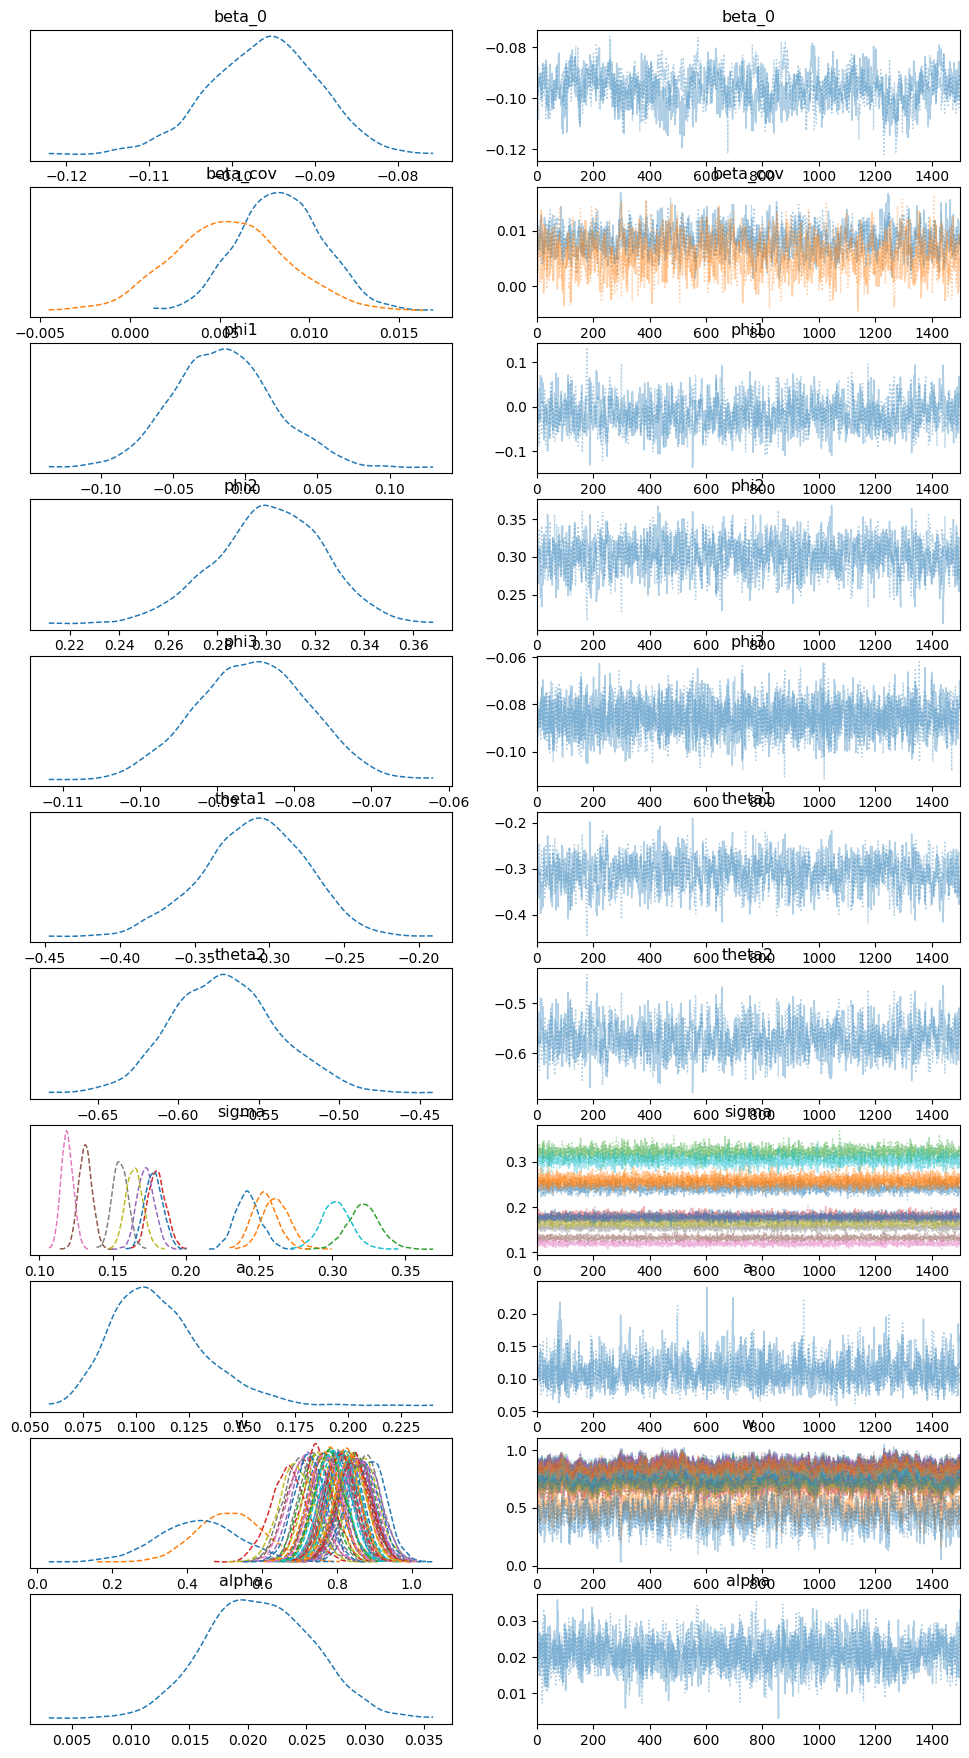

In [15]:
az.plot_trace(arima_az, var_names=["beta_0", "beta_cov", "phi1", "phi2", "phi3", "theta1", "theta2", "sigma","a", "w", "alpha"], combined = True)
plt.show()

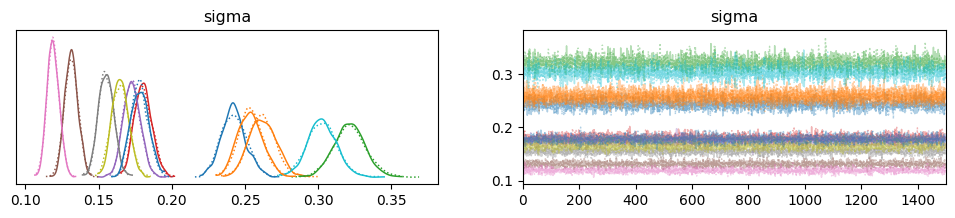

In [26]:
az.plot_trace(arima_az, var_names=["sigma"], combined = False, compact=True)
plt.show()

In [49]:
#how many diverging iterations
np.sum(arima_az.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(0)

In [50]:
waic_results = az.waic(arima_az,var_name="log_lik")
print(waic_results)
loo_results = az.loo(arima_az, var_name="log_lik")
print(loo_results)

/Users/indiaermacora/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 3000 posterior samples and 22630 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -14210.93   183.76
p_waic      870.86        -

There has been a warning during the calculation. Please check the results.


/Users/indiaermacora/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 3000 posterior samples and 22630 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -14504.59   185.12
p_loo     1164.52        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     21308   94.2%
 (0.5, 0.7]   (ok)         431    1.9%
   (0.7, 1]   (bad)        747    3.3%
   (1, Inf)   (very bad)   144    0.6%



In [51]:
#to save the model 
import pickle
pickle.dump(fit, open('arima_model_varmensile.p', 'wb'))